In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/github_repositories/my_repositories/TestingTISE/src/FEMTISE_tutorials`


In [2]:
develop_package = false
computer = "notebook"

if computer == "notebook"
    path_repo = "/home/mendez/github_repositories/my_repositories/"
elseif computer == "pcfamaf"
    path_repo = "/home/martin/github_repositories/my_repositories/"
elseif computer == "ccad"
    path_repo = "/home/martinmendez/github_repositories/my_repositories/"
end

develop_package ? Pkg.develop(path=path_repo*"FEMTISE.jl") : nothing

In [4]:
install_pkg = false
if install_pkg
    Pkg.add("Revise")
    Pkg.add("Gridap")
    Pkg.add("Plots")
end
using Revise;
using FEMTISE;
using Gridap;
using Plots;

In [5]:
include(path_repo*"FEMTISE.jl/test/test_1d_kronig_penney/miscellaneous_functions.jl")

symetric_kronig_penney (generic function with 1 method)

In [7]:
# Set atomic unit system
const Bohr_radius_meter=5.29177210903e−11;                              # [m]
const Angstrom_to_meter=1e−10;                                          # [m/Å]
const Angstrom_to_au=Angstrom_to_meter*(1.0/Bohr_radius_meter);         # [au/Å]
const Nanometer_to_au=(1e-9)*(1.0/Angstrom_to_meter)*Angstrom_to_au;    # [au/nm]
const Electronvolt_to_au=0.036749405469679;                             # [au/Ev]

In [7]:
grid_size_length=276;
potential_depth=-0.5;
distance_between_wells=11;
well_width=1;
num_ions=23;
space_discretization=0.01;

unit_cell_potential=distance_between_wells+well_width;

quantity_check = num_ions*unit_cell_potential;
(grid_size_length ≥ quantity_check) ? println("The value of grid size length is ok (≥ $(quantity_check)).") : println("Increase grid size length, must be grid_size_length ≥ $(quantity_check).")

The value of grid size length is ok (≥ 276).


In [8]:
grid_type="simple_line";
params_model=("./","model1D",(-0.5*grid_size_length,0.5*grid_size_length),space_discretization);
model1D=make_model(grid_type,params_model);
rm(params_model[1]*params_model[2]*".msh")

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.0147033s, CPU 0.013233s)
Info    : 27601 nodes 27602 elements
Info    : Writing './model1D.msh'...
Info    : Done writing './model1D.msh'
Info    : Reading './model1D.msh'...
Info    : 3 entities
Info    : 27601 nodes
Info    : 27602 elements
Info    : Done reading './model1D.msh'


Make coordinate vector

In [9]:
point_number=round(Int,abs(grid_size_length/space_discretization)+1)
space_coordinate,points=space_coord((-0.5*grid_size_length,0.5*grid_size_length),space_discretization,point_number-1;dimension="1D")

([-138.0, -137.99, -137.98, -137.97, -137.96, -137.95, -137.94, -137.93, -137.92, -137.91  …  137.90000000000003, 137.91000000000003, 137.92000000000002, 137.93, 137.94, 137.95, 137.95999999999998, 137.97000000000003, 137.98000000000002, 137.99], VectorValue{1, Float64}[(-138.0,), (-137.99,), (-137.98,), (-137.97,), (-137.96,), (-137.95,), (-137.94,), (-137.93,), (-137.92,), (-137.91,)  …  (137.90000000000003,), (137.91000000000003,), (137.92000000000002,), (137.93,), (137.94,), (137.95,), (137.95999999999998,), (137.97000000000003,), (137.98000000000002,), (137.99,)])

Plotting potential function

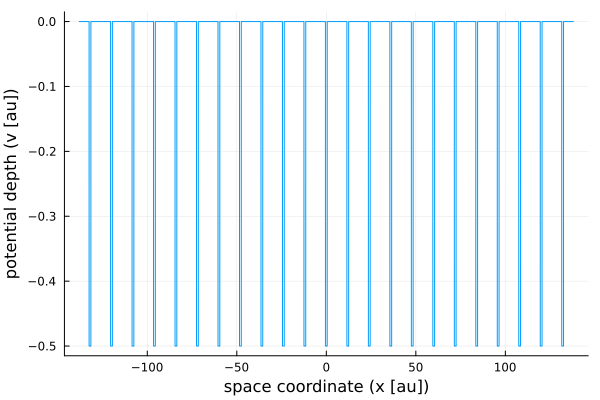

In [15]:
fig = plot(space_coordinate,symetric_kronig_penney(space_coordinate,num_ions,unit_cell_potential,well_width,potential_depth),label="")
fig = plot!(fig,xlabel="space coordinate (x [au])",ylabel="potential depth (v [au])")
display(fig)

In [16]:
BC_type="FullDirichlet";
FullDirichlet_values,FullDirichlet_tags=make_boundary_conditions(grid_type,BC_type,ComplexF64);

interior_FE_domain,differential_interior_FE_domain,boundary_FE_domain,differential_boundary_FE_domain = measures(model1D,3,FullDirichlet_tags)

reff = ReferenceFE(lagrangian,Float64,2)

TestSpace,TrialSpace = fe_spaces(model1D,reff,grid_type;BC_type=BC_type,TypeData=ComplexF64)

p,q,r = kronig_penney_sturm_liouville((num_ions,unit_cell_potential,well_width,potential_depth))

eigen_energies,eigen_states = eigen_values_and_eigen_vectors(p,q,r,differential_interior_FE_domain,TrialSpace,TestSpace;
params=(10,1e-9,500,:none,potential_depth))

(ComplexF64[-0.09666332271810901 - 5.5006353890207724e-18im, -0.09660919290945497 - 9.86335133762521e-18im, -0.09651985266100094 - 7.369390302932625e-19im, -0.09639661403879424 + 3.745669937431199e-18im, -0.09624130920256818 + 2.2915464231635647e-17im, -0.09605628435896962 + 2.5282790469015662e-17im, -0.09584439011111034 + 1.2934029968007778e-17im, -0.09560896679006858 + 3.193398330687521e-17im, -0.09535382309881824 - 9.696715804857894e-18im, -0.09508320613519883 + 5.28558092201171e-17im], CellField[SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction(), SingleFieldFEFunction()])

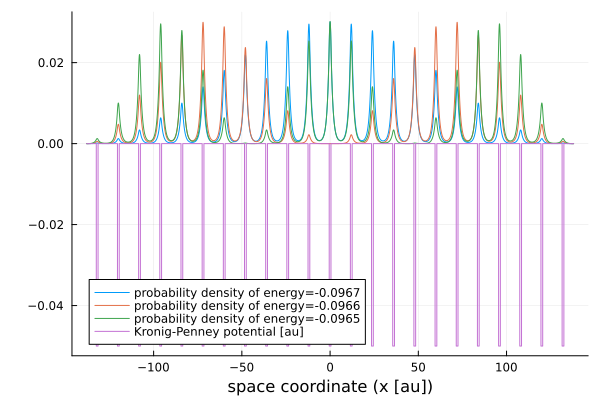

In [19]:
fig=plot()
probability_densities=FEMTISE.density(eigen_states)
for i in 1:3#eachindex(ϕ)
    fig=plot!(space_coordinate,probability_densities[i].(points),
    label="probability density of energy=$(round(real(eigen_energies[i]),digits=4))",
    legend=:bottomleft)
end

fig=plot!(xlabel="space coordinate (x [au])",ylabel=" ")
fig=plot!(space_coordinate,0.1 .* symetric_kronig_penney(space_coordinate,num_ions,unit_cell_potential,well_width,potential_depth),
label="Kronig-Penney potential [au]")

display(fig)

In [20]:
savefig(fig,"010_example_kronig-penney.pdf")

"/home/mendez/github_repositories/my_repositories/TestingTISE/src/FEMTISE_tutorials/010_example_kronig-penney.pdf"